In [3]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [6]:
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)


Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


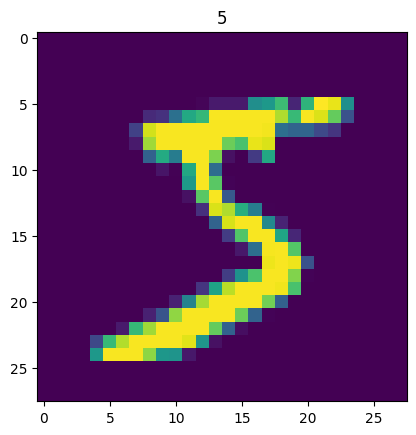

In [7]:
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [8]:
# calculate the confusion matrix
from sklearn.metrics import confusion_matrix

def evaluator(y, y_pred):    
    
    matrix = confusion_matrix(y, y_pred)
    
    print('Confusion matrix:\n', matrix)
    
####################################################################################################

## Part 1

In [9]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    def sigmoid(self, x):

        return 1/(1 + torch.exp(-x))


    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]

        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:

                hidden = self.sigmoid(torch.mm(x_batch, self.W1))
                output = self.sigmoid(torch.mm(hidden, self.W2))
              
                output_error = output - y_batch
                loss += torch.mean(pow(output_error, 2))
                delta_output = output_error / self.batch_size
                delta_hidden = torch.mm(delta_output, self.W2.t()) * hidden

        
                self.W1 -= self.learning_rate * torch.mm(x_batch.t(), delta_hidden)
                self.W2 -= self.learning_rate * torch.mm(hidden.t(), delta_output)

            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
   
    def predict(self, x):
     
        h = self.sigmoid(torch.mm(x, self.W1))
        output = self.sigmoid(torch.mm(h, self.W2))
        y_pred = torch.argmax(output, dim=1)
        
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [10]:
x_train = data_dict['x_train'].to(device)
y_train = data_dict['y_train'].to(device)
x_test = data_dict['x_test'].to(device)
y_test = data_dict['y_test'].to(device)


model = NN(0.2, 1000, 128, 64, device)
a = model.train(x_train, y_train, x_test, y_test)


epoch 1, loss 25.6947, train acc 0.730, validation acc 0.733
epoch 2, loss 16.1646, train acc 0.797, validation acc 0.802
epoch 3, loss 13.4324, train acc 0.819, validation acc 0.823
epoch 4, loss 12.0199, train acc 0.830, validation acc 0.836
epoch 5, loss 11.1429, train acc 0.841, validation acc 0.847
epoch 6, loss 10.5108, train acc 0.849, validation acc 0.854
epoch 7, loss 10.0613, train acc 0.856, validation acc 0.860
epoch 8, loss 9.7167, train acc 0.859, validation acc 0.866
epoch 9, loss 9.5105, train acc 0.861, validation acc 0.867
epoch 10, loss 9.4672, train acc 0.862, validation acc 0.871
epoch 11, loss 9.3873, train acc 0.863, validation acc 0.871
epoch 12, loss 9.3228, train acc 0.864, validation acc 0.871
epoch 13, loss 9.3160, train acc 0.864, validation acc 0.871
epoch 14, loss 9.3131, train acc 0.864, validation acc 0.873
epoch 15, loss 9.3221, train acc 0.865, validation acc 0.873
epoch 16, loss 9.3337, train acc 0.866, validation acc 0.869
epoch 17, loss 9.3806, tra

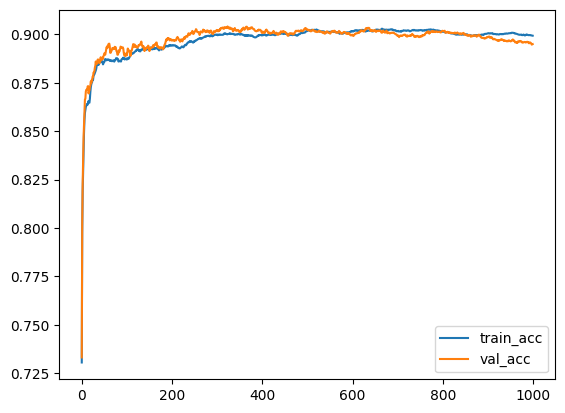

In [11]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

### Model2-1

In [12]:
import tensorflow as tf
import numpy as np


In [13]:
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict


In [14]:
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)


Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


### Model2-2

In [15]:
class tfv():

    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, dtype):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    

    def train(self, x, y, xtest, ytest, verbose=1):
        n_train = x.shape[0]
        n_val = xtest.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]

        self.W1 = tf.Variable(tf.random.normal([input_size, self.hidden_size], dtype=self.dtype))
        self.W2 = tf.Variable(tf.random.normal([self.hidden_size, num_classes], dtype=self.dtype))
        
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:

                hidden = self.sigmoid(tf.matmul(x_batch, self.W1))
                output = self.sigmoid(tf.matmul(hidden, self.W2))

                output_error = output - y_batch
                loss += tf.reduce_mean(tf.pow(output_error, 2))
                delta_output = output_error / self.batch_size
                delta_hidden = tf.matmul(delta_output, tf.transpose(self.W2)) * hidden

                self.W1.assign_sub(self.learning_rate * tf.matmul(tf.transpose(x_batch), delta_hidden))
                self.W2.assign_sub(self.learning_rate * tf.matmul(tf.transpose(hidden), delta_output))

            y_pred = self.predict(x)
            train_acc = np.mean(np.argmax(y, axis=1) == y_pred)
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss.numpy())
            
            y_pred = self.predict(xtest)
            val_acc = np.mean(np.argmax(ytest, axis=1) == y_pred)
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                      % (i + 1, loss, train_acc, val_acc))
    
    def predict(self, x):
        h = self.sigmoid(tf.matmul(x, self.W1))
        output = self.sigmoid(tf.matmul(h, self.W2))
        y_pred = np.argmax(output, axis=1)
        return y_pred
####################################################################################################

In [18]:
xtrain = tf.convert_to_tensor(x_train, dtype=tf.float32)
ytrain = tf.convert_to_tensor(y_train, dtype=tf.float32)
xtest = tf.convert_to_tensor(x_test, dtype=tf.float32)
ytest = tf.convert_to_tensor(y_test, dtype=tf.float32)

model1 = tfv(0.2, 50, 128, 64, tf.float32)
model1.train(xtrain, ytrain, xtest, ytest)


C:\Users\mdere\AppData\Local\Temp\ipykernel_15640\2649798989.py:13: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


epoch 1, loss 21.3707, train acc 0.743, validation acc 0.751
epoch 2, loss 14.9050, train acc 0.802, validation acc 0.812
epoch 3, loss 13.0380, train acc 0.823, validation acc 0.832
epoch 4, loss 11.8869, train acc 0.835, validation acc 0.839
epoch 5, loss 11.1510, train acc 0.842, validation acc 0.845
epoch 6, loss 10.5708, train acc 0.849, validation acc 0.849
epoch 7, loss 10.0777, train acc 0.854, validation acc 0.854
epoch 8, loss 9.7415, train acc 0.859, validation acc 0.860
epoch 9, loss 9.4849, train acc 0.861, validation acc 0.861
epoch 10, loss 9.3042, train acc 0.863, validation acc 0.863
epoch 11, loss 9.1857, train acc 0.864, validation acc 0.864
epoch 12, loss 9.0810, train acc 0.865, validation acc 0.862
epoch 13, loss 8.9832, train acc 0.867, validation acc 0.865
epoch 14, loss 8.9027, train acc 0.868, validation acc 0.867
epoch 15, loss 8.8507, train acc 0.869, validation acc 0.867
epoch 16, loss 8.7859, train acc 0.869, validation acc 0.869
epoch 17, loss 8.7122, tra

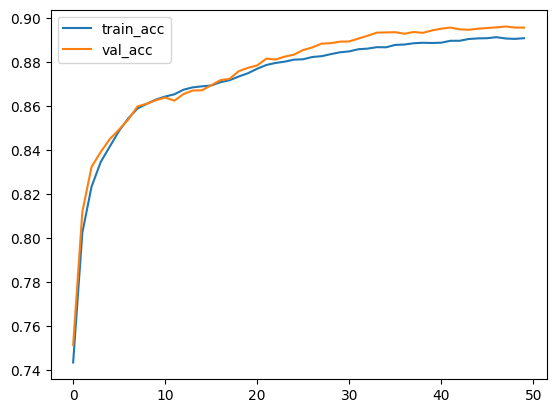

In [19]:
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['val_acc'], label='val_acc')
plt.legend()
plt.show()
